In [15]:
import matplotlib.pyplot as plt # Plot data
import numpy as np    # Math features
import pandas as pd   # Manipulate Data
from py_functions import ProcessVibrationData # Repository processing functions

# Open data

In [16]:
folder_path = './data/imbalance/imbalance/20g/'
# Initialize process object
vibration_data_o = ProcessVibrationData(path2data=folder_path)
# Open dataframe
vibration_data_o.open_df()
# Rename dataframe columns
vibration_data_o.rename_df_columns()

# Process data

In [17]:
# Get tachometer frequency 
tachometer_freq = vibration_data_o.get_tachometer_freq()

In [18]:
# # FFT parameters
sel_fft_df = vibration_data_o.get_sel_fft_df(tachometer_freq=tachometer_freq)

In [19]:
# # Filter signal - Low pass filter
sel_fft_df_filt = vibration_data_o.lowpass_filter_df(sel_fft_df)

In [20]:
# # Calculate FFT
df_fft = vibration_data_o.get_df_fft(sel_fft_df_filt)

# Plot data

(0.0, 6000.0)

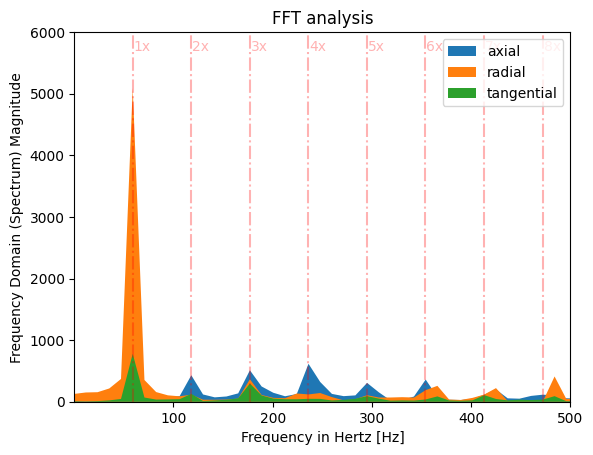

In [21]:
# Define plot variables
fig, ax = plt.subplots()
xlim = 500
ylim = 6000

# Plot lines
column_str = "under_bear_acc1_axial"
ax.stackplot(df_fft[column_str + "_y"], np.abs(df_fft[column_str + "_x"]))
column_str = "under_bear_acc1_radial"
ax.stackplot(df_fft[column_str + "_y"], np.abs(df_fft[column_str + "_x"]))
column_str = "under_bear_acc1_tang"
ax.stackplot(df_fft[column_str + "_y"], np.abs(df_fft[column_str + "_x"]))

# Add harmonics lines
for i in range(1,9):
    ax.axvline(x = tachometer_freq * i, color = 'r', linestyle = "-.", alpha = 0.3)
    ax.text(tachometer_freq * i + 1, ylim - 300, str(i) + 'x', color = 'r', alpha = 0.3)

# Config plot
ax.legend(['axial', 'radial', 'tangential'])
ax.set_title("FFT analysis")
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(vibration_data_o.acc1_min_freq_range, xlim)
ax.set_ylim(0, ylim)